<a href="https://colab.research.google.com/github/hkhong72/big_data/blob/main/221028_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import mnist # MNIST 데이터 호출
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import sys
# KMP에러 나는걸방지
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) / 255 # 4번째차원 : '커널의 채널' 우리는 흑백이니까 1을 썼지만, 컬러면 rgb는 3
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(float) / 255

y_train = to_categorical(y_train) # 넘파이배열을 원핫인코딩 : to_categorical
y_test = to_categorical(y_test)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1),
                       activation='relu')) 
# 이미지한장이 들어오면 3by3 커널을 만드는데, 출력이미지는 32장으로 만들거다(커널을 32개를 두고),
# (3by3커널의 각각의 값이 w웨이파라미터임. 이미지쉐입은28,28,1이다. 
# 커널별로 b바이아스가 생성됨, -> 32개생성 
# 32장으로 뽑는이유 : 각각의 커널이 개별적인활동을한다,
# : 각각의 전체이미지 외곽을 중심으로, 어떤커널은 눈주위를 위주로, 어떤커널은 입주위, ...  이렇게 커널이 분업화 됨
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu')) # 1장들어올때 커널 64개, 바이아스 64개 
# 처음에 1장이 들어올 때 32개가 생성되었고, 다음엔 32장이 들어와서 64개가 생기기때문에 32 * 64개가 생김
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten()) #몇차원이들어오든 1차원으로 만들어줌  -> Dense층으로 집어넣기 위함
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [ ]:
# 1. (1) * (3 x 3) * (32) + 32=> w = 288 / bias = 32 / total = 320 => 이미지크기 28* 28 => (28-2) * (28-2)
# 2. (32) *  (3 x 3)* (64) + 64 =>  w =18432 / bias = 32 / total = 18496 => 이미지크기 (28-2) * (28-2) => (28-4) * (28-4)
# 3. 이미지 크기 24 * 24였는데 (2,2) maxpooling 하면서 1/4토막 > 가로세로 절반됨
# 4. Flatten ==> 1차원으로 눌러서 12 * 12 크기의 64개 ==> 입력 9216
# 5. (9216) * (128) + 128 =>  w = 1179648 / bias = 128 / total = 1179776
# 6. (128) * (10) + 10 = w = 1280 / bias = 10 / total = 1290
# 7. Dropout 은 파라미터 영향 x

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath='data/mnist_cnn.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=200, verbose=0, callbacks=[checkpointer, early_stopping])


Epoch 1: val_loss improved from inf to 0.07936, saving model to data\mnist_cnn.hdf5

Epoch 2: val_loss improved from 0.07936 to 0.05471, saving model to data\mnist_cnn.hdf5

Epoch 3: val_loss improved from 0.05471 to 0.04647, saving model to data\mnist_cnn.hdf5

Epoch 4: val_loss improved from 0.04647 to 0.04458, saving model to data\mnist_cnn.hdf5

Epoch 5: val_loss improved from 0.04458 to 0.04256, saving model to data\mnist_cnn.hdf5

Epoch 6: val_loss improved from 0.04256 to 0.04102, saving model to data\mnist_cnn.hdf5

Epoch 7: val_loss did not improve from 0.04102

Epoch 8: val_loss did not improve from 0.04102

Epoch 9: val_loss did not improve from 0.04102

Epoch 10: val_loss did not improve from 0.04102

Epoch 11: val_loss did not improve from 0.04102

Epoch 12: val_loss improved from 0.04102 to 0.04025, saving model to data\mnist_cnn.hdf5

Epoch 13: val_loss improved from 0.04025 to 0.03975, saving model to data\mnist_cnn.hdf5

Epoch 14: val_loss did not improve from 0.03975

In [ ]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.0337 - accuracy: 0.9916

 Test Accuracy: 0.9916


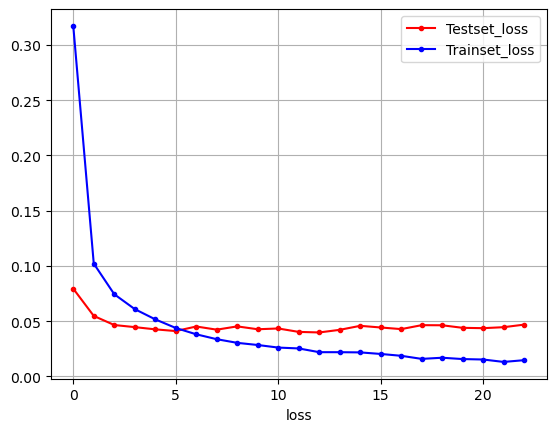

In [ ]:
# 학습셋의 오차를 그래프로 표현해보자
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프 만들기
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드 주기 + 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.xlabel('loss')
plt.show()